# Лабораторная работа 1  
## Восстановление частоты несущей в системах с линейной модуляцией  
Выполнила: Шаповалова Виктория, ИКТ-11М.  

В ходе лабораторной работы требовалось реализовать одну из известных схем (алгоритмов) для оценки частоты несущего колебания и определить ее возможности.

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [117]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import scipy
from scipy import signal
from scipy.signal import max_len_seq
from ModulationPy import PSKModem
from scipy.fftpack import fft, ifft, fftfreq
import time

### 2. Задание параметров  
В данном разделе задаются параметры, которые будут использованы в ходе выполнения работы.

In [ ]:
data_len = 1024 #длина информационной последовательности
order = 8 #порядок модуляции
mod_shift = 0 #поворот созвездия
offset = 1e5 #смещение по частоте
fs = 1e8 #частота дискретизации 
snr = 10 #отношение сигнал/шум


### 3. Генерация случайного сигнала  
В данном разделе с помощью функции рандома генерируется информационный сигнал длины data_len для дальнейшей передачи.

In [ ]:
data = []  
for i in range(data_len):
    data.append(random.randint(0, order-1)) 


### 4. PSK модуляция

В данном разделе определяется модуляция 8-PSK и применяется к сгенерированным ранее данным. Нулевая точка соответствует нулевому значению комплексной плоскости. 

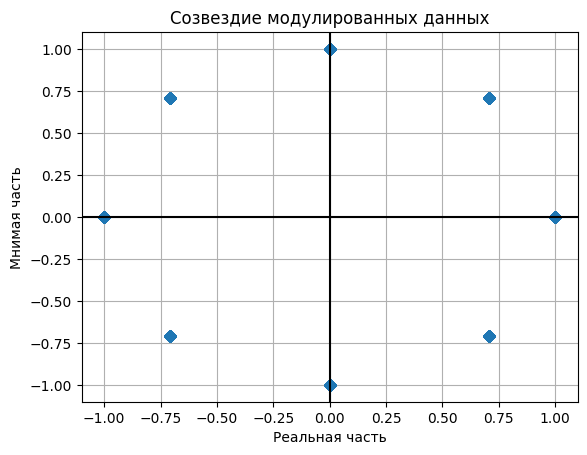

In [120]:
modem = PSKModem(order, mod_shift, 
                 bin_input=False,
                 soft_decision=False,
                 bin_output=False)

data_mod = modem.modulate(data) 

plt.figure(1)
plt.plot(np.real(data_mod),np.imag(data_mod), 'D')
plt.title('Созвездие модулированных данных')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.grid()

### 5. Частотный сдвиг  
В данном разделе к модулированным данным применяется частотный сдвиг, который приводит к размазыванию созвездия по единичной окружности комплексной плоскости. Чем больше параметр offset, тем к большему размазыванию он приводит. При значении 4e5 появляется "окружность" вместо созвездия модуляции.

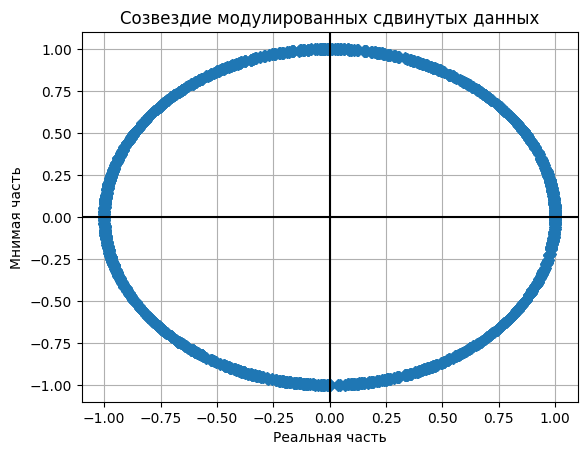

In [121]:
def freq_offset(data, offset, fs):
    Ts = 1/fs 
    t = np.arange(0, Ts*(len(data)-0.5), Ts) 
    data = data * np.exp(1j*2*np.pi*offset*t) 
    return data

data_mod_offset = freq_offset(data_mod, offset, fs)
plt.figure(1)
plt.plot(np.real(data_mod_offset),np.imag(data_mod_offset), 'D')
plt.title('Созвездие модулированных сдвинутых данных')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.grid()

### 5. Добавление шума 
На следующем шаге производится генерация и добавления АБГШ для действительной и мнимой части. На графике показано созвездие модулированного сигнала с частотным сдвигом и шумом. Уменьшение отношения сигнал/шум приводит к ухудшению созвездия. При отношении 5 дБ "кольцо" созвездия практически неразличимо.

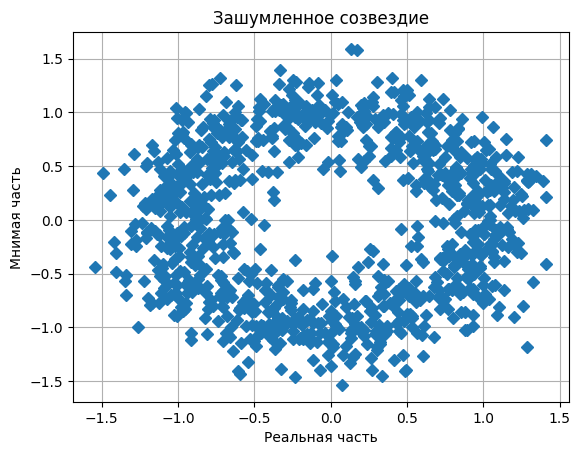

In [122]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise

awgn_noise = awgn(data_mod_offset, snr)
tx = data_mod_offset + awgn_noise

plt.figure(1)
plt.plot(tx.real, tx.imag, 'D')
plt.title('Зашумленное созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.grid()

### 6. Система восстановления
Система восстановления частоты выполняет две основные функции:   
1. вычисляет оценку v смещения несущей частоты;   
2. компенсирует это смещение путем обратного вращения принятого набора сигналов.  
Существует два случая, когда сдвиг значительно меньше, чем 1/T, и, когда сдвиг совпадает порядком с 1/Т.  В первом случае символы данных могут быть неизвестны, однако информация о времени может быть восстановлена даже при наличии умеренных смещений частоты, а затем использована для оценки v. Во втором случае символы данных, фаза несущей и, возможно, такты неизвестны.  

Далее будет рассмотрена схема Кая, работающая для первого случая.  
![sync](kays2.drawio.svg)  
Принятый сигнал подается на вход согласованного фильтр. Затем отсчеты определенных моментов времени перемножаются на комплексно-сопряженные отсчеты ожидаемых модулированных данных. В результате определяется сигнал ошибки.

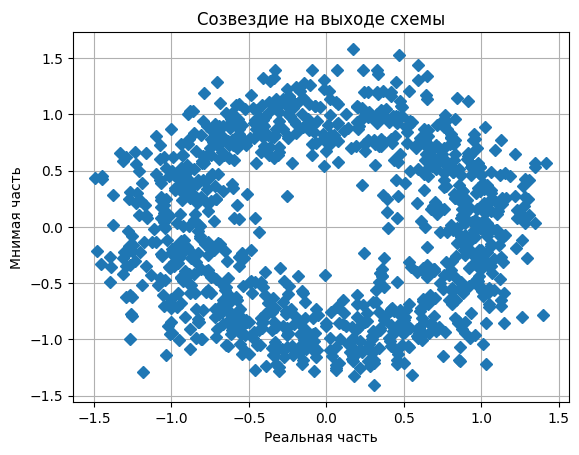

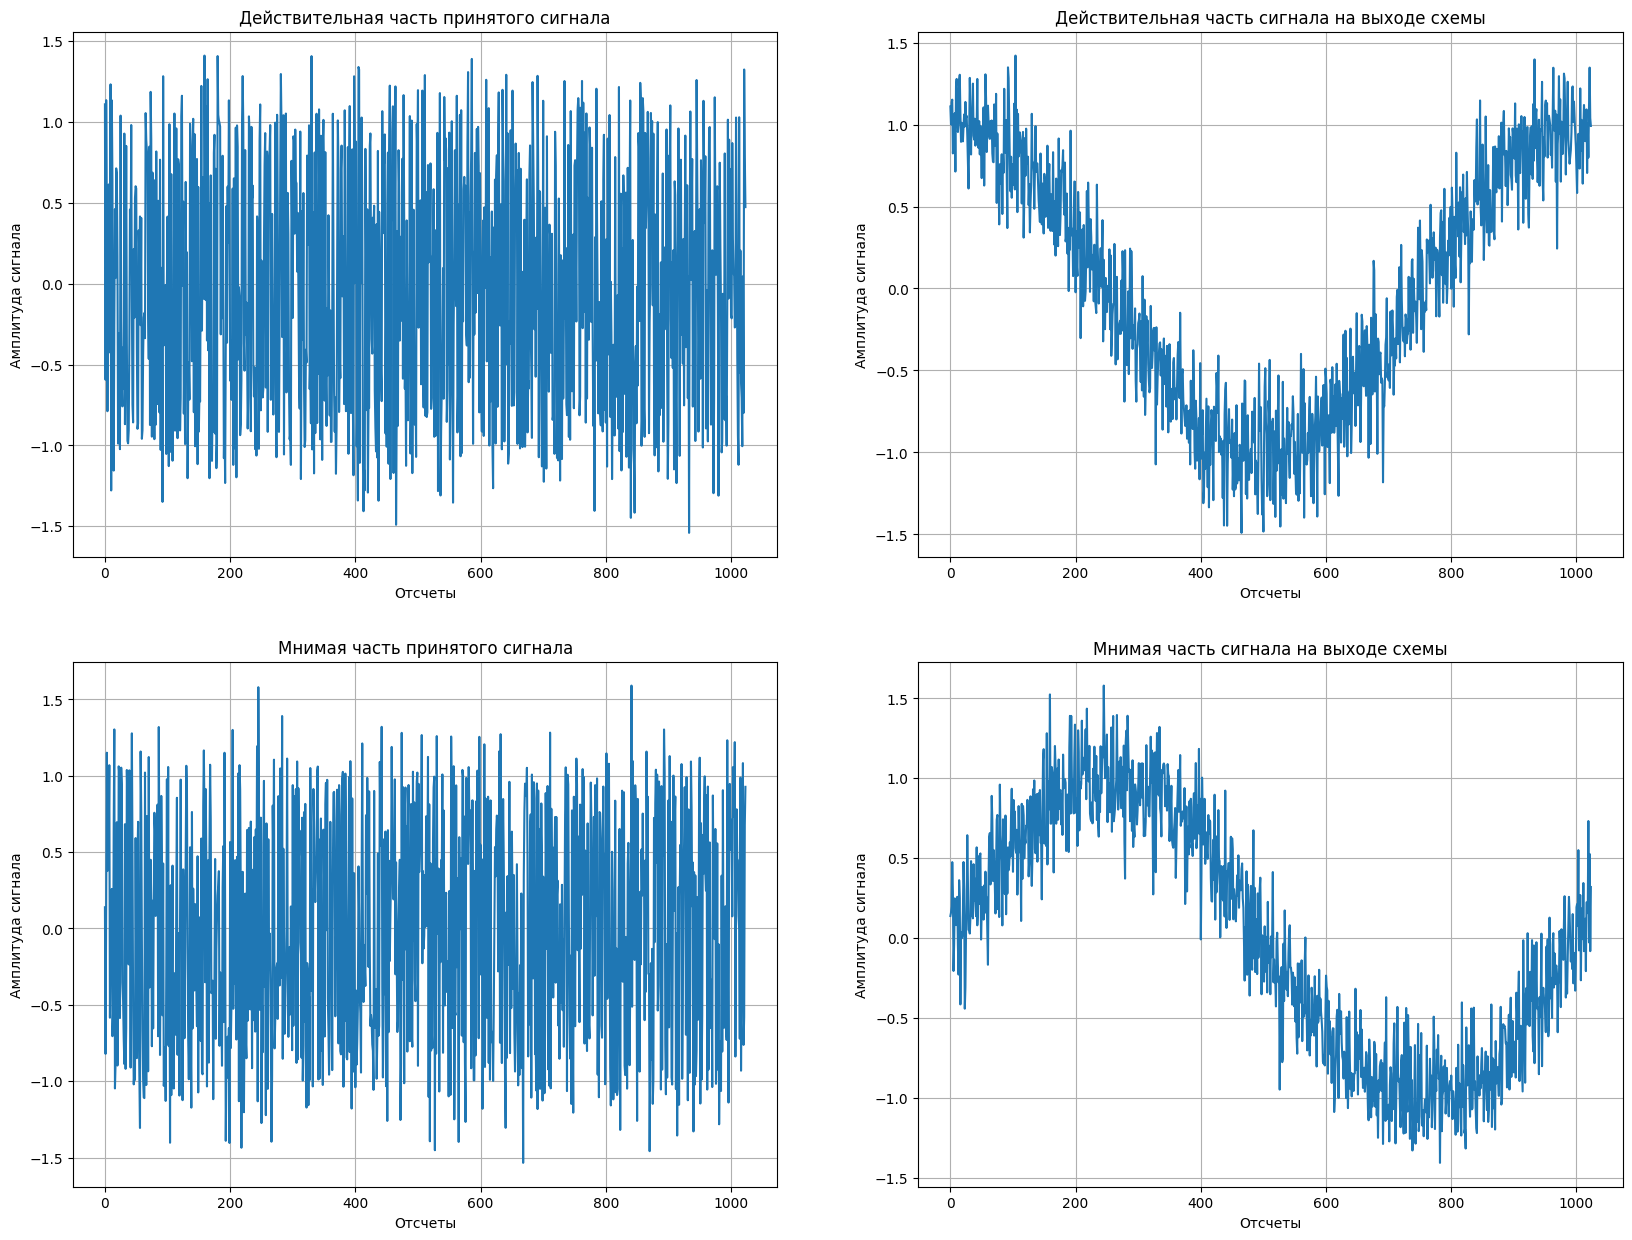

In [123]:
rx = tx
err_data = rx * np.conj(1*data_mod.real + 1j*data_mod.imag)
plt.figure(1)
plt.plot(err_data.real, err_data.imag, 'D')
plt.title('Cозвездие на выходе схемы')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.grid()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,15))

ax1.title.set_text('Действительная часть принятого сигнала')
ax1.plot(rx.real)
ax1.set_xlabel("Отсчеты")
ax1.set_ylabel("Амплитуда сигнала")
ax1.grid()

ax2.title.set_text('Действительная часть сигнала на выходе схемы')
ax2.plot(err_data.real)
ax2.set_xlabel("Отсчеты")
ax2.set_ylabel("Амплитуда сигнала")
ax2.grid()

ax3.title.set_text('Мнимая часть принятого сигнала')
ax3.plot(rx.imag)
ax3.set_xlabel("Отсчеты")
ax3.set_ylabel("Амплитуда сигнала")
ax3.grid()

ax4.title.set_text('Мнимая часть сигнала на выходе схемы')
ax4.plot(err_data.imag)
ax4.set_xlabel("Отсчеты")
ax4.set_ylabel("Амплитуда сигнала")
ax4.grid()

Полученное созвездие на выходе не имеет значительных отличий от переданного, поскольку оно отображает созвездие вектора ошибок.   
Отличие временного представления сигнала до и после схемы Кая заметно. После схемы косинусоида и синусоида сигнала стали различимы. 

В случае, если поставить смещение одного порядка с 1/T, то есть второй вариант, получатся результаты, как на рисунках ниже. Видно, что были переданы данные с модуляцией 8-PSK, а после схемы оно уже не определяется. Действительно, для данного случая схема Кая непригодна.

![sync](lab1__2.PNG)  
![sync](lab1__3.PNG)

Далее продемонстрирован спектр сигнала на выходе схемы. Поскольку на выходе схемы определяется вектор ошибок, она определяет частоту смещения. А значит основной пик схемы должен принадлежать частоте смещения.  
На полученном графике пик примерно соответствует значению offset, которое было задано. 

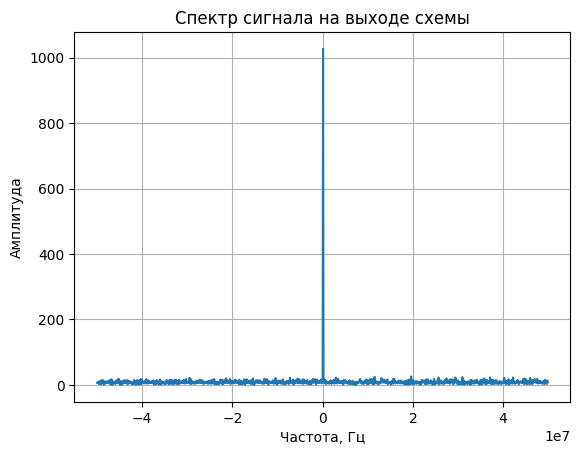

In [124]:
S = abs(fft(err_data))
xf = fftfreq(np.size(err_data), 1/fs)

plt.figure(0)
plt.title('Спектр сигнала на выходе схемы')
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.plot(xf[0:np.size(xf)], S[0:np.size(xf)])
plt.grid()

Чтобы получить значение смещение посчитано значение по формуле:  
$$ \hat{v} = {1}/{2 \pi T} \sum_{i=1}^{L_0 - 1} \gamma (k) arg [z(k) z^*(k-1)] $$  

Полученное значение совпадает с ожидаемым значением параметра offset при нулевом шуме. 

In [125]:
def count_v (err_data, data_len):
    sum_func = 0
    for i in range(1,data_len-1,1):
        gamma = (3*data_len)/(2*(data_len**2-1))*(1-((2*i-data_len)/data_len)**2)
        z = (err_data.real[i] + 1j*err_data.imag[i])*(err_data.real[i-1] - 1j*err_data.imag[i-1])
        arg = math.atan2(z.imag, z.real)
        sum_func = sum_func + gamma*arg
    v = fs/(2*np.pi)*sum_func
    return(v)

print(count_v(err_data, data_len))


99626.41356898648


Увеличение уровня шума повышает возникающую погрешность, поэтому далее был построен график зависимости ошибки определяемого смещения от отношения сигнал/шум. На графике видно, что, начиная с 0 дБ, в отрицательной области погрешность становится слишком высокой и система работает неверно.

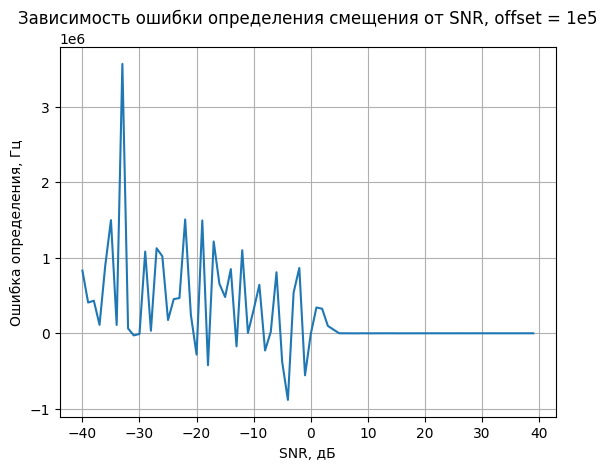

In [126]:
ARR_V = []
SNRS = []
for i in range (-40,40,1):
    SNRS.append(i)
    awgn_noise = awgn(data_mod_offset, i)
    tx = data_mod_offset + awgn_noise
    err_data = tx * np.conj(1*data_mod.real + 1j*data_mod.imag)
    diff = offset - count_v(err_data, data_len)
    ARR_V.append(diff)

plt.figure(0)
plt.title('Зависимость ошибки определения смещения от SNR, offset = 1e5')
plt.xlabel("SNR, дБ")
plt.ylabel("Ошибка определения, Гц")
plt.plot(SNRS, ARR_V)
plt.grid()

Также был построен график зависимости ошибки определения смещения от величины устанавливаемого смещения. По рисунку видно, что при сдвиге значительно меньшем, чем 1/T, разность незначительна и система может считаться рабочей. Когда сдвиг приближается порядком к 1/Т, то ошибка резко возрастает, что подтверждает, что схема Кая не подходит для этого случая.

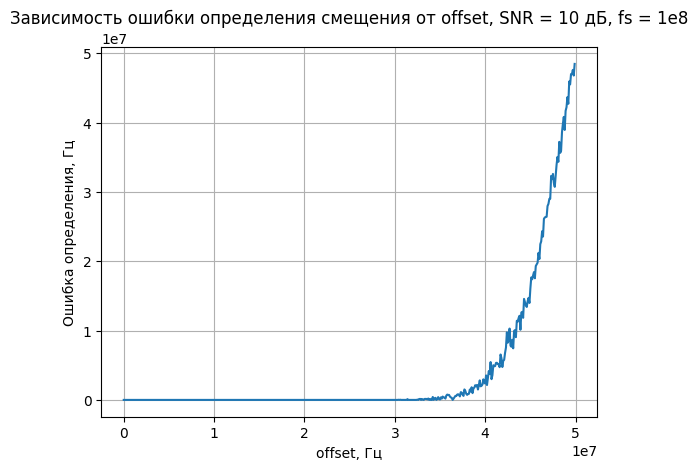

In [127]:
ARR_V = []
OFFSETS = []
for i in range (0,50000000,100000):
    OFFSETS.append(i)
    data_mod_offset = freq_offset(data_mod, i, fs)
    awgn_noise = awgn(data_mod_offset, snr)
    tx = data_mod_offset + awgn_noise
    err_data = tx * np.conj(1*data_mod.real + 1j*data_mod.imag)
    diff = i - count_v(err_data, data_len)
    ARR_V.append(diff)

plt.figure(0)
plt.title('Зависимость ошибки определения смещения от offset, SNR = 10 дБ, fs = 1e8')
plt.xlabel("offset, Гц")
plt.ylabel("Ошибка определения, Гц")
plt.plot(OFFSETS, ARR_V)
plt.grid()

## Вывод
В ходе выполнения лабораторной работы было рассмотрено восстановление несущей в системах с линейной модуляцией на основе схемы Кая.  
В первую очередь был сформирован сигнал, промодулирован с помощью 8-PSK, затем к модулированным данным применяется частотный сдвиг, который приводит к размазыванию созвездия по окружности комплексной плоскости. Чем больше значение сдвига, тем к большему размазыванию он приводит. Далее к сигналу прибавляется АБГШ.   
Затем выполняется схема Кая, которая вычисляет оценку смещения несущей. По теоретическим сведениям схема Кая предназначена для случая, когда сдвиг значительно меньше, чем 1/T. В первую очередь было проведено сравнение созвездий и временных диаграмм принятого сигнала и сигнала на выходе схемы. Также был получен спектр сигнала на выходе схемы. Также по теоретической формуле было вычислено значение смещения и сравнено с заданным. Поскольку вычисленное значение имело некоторую погрешность, после утверждения корректности работы схемы было проведено исследование зависимости ошибки определения смещения от отношения сигнал/шум. Начиная с 0 дБ, в отрицательной области погрешность становится слишком высокой и система работает неверно. Также построена зависимость ошибки определения смещения от величины задаваемого смещения. График подтверждает, что при сдвиге значительно меньшем, чем 1/T, разность незначительна и система может считаться рабочей. Когда сдвиг приближается порядком к 1/Т, то ошибка резко возрастает, что подтверждает, что схема Кая не подходит для этого случая.